In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from shapely import Polygon
import geopandas as gpd
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
geom = Polygon([
    (-91.3011932, 33.852768),
    (-90.9098053, 33.8413567),
    (-90.9194183, 33.5069017),
    (-91.2957001, 33.509193),
    (-91.3005066, 33.8579026)
])

gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326")
gdf = gdf.to_crs(32615)  # UTM 15N
selected_geom = gdf.geometry.union_all().envelope

In [3]:
items_gdf = pc_query(
    collections="landsat-c2-l2",
    geometry=selected_geom,
    datetime="1984/2024",
    crs=gdf.crs,
    query={"eo:cloud_cover": {"lt": 5}} # return scenes with less than 50% cloud cover 
)
print(f"Found {len(items_gdf)} items")

Found 1459 items


In [4]:
client = Client(n_workers=os.cpu_count(), memory_limit="4GB")
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 89.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33301,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39353,Total threads: 1
Dashboard: http://127.0.0.1:45105/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:40071,


In [ ]:
da = prepare_timeseries(
    items_gdf,
    geometry=selected_geom,
    crs=gdf.crs,
    bands=["green", "nir08", "qa_pixel"],
    chunks={"time": 1, "x": -1, "y": -1},
    masked=True,
    max_workers=4,
    reproject_num_threads=-1,  # Use all available CPUs for reprojection
    reproject_mem_limit=256,  # 256 MB memory limit for reprojection
)

Processing items:   1%|          | 5/913 [00:18<44:35,  2.95s/timestep]  

In [ ]:
qa = da.sel(band="qa_pixel").astype("uint32")

mask = (
    ((qa & (1 << 3)) == 0) &  # cloud
    ((qa & (1 << 4)) == 0) &  # cloud shadow
    ((qa & (1 << 5)) == 0) &  # snow
    ((qa & (1 << 7)) == 0)    # water
)

da = da.where(~mask)
da = da.rio.write_nodata(np.nan)

In [ ]:
def dn2sr(da):
    """
    Convert Digital Number (DN) to Surface Reflectance (SR) for Landsat Collection 2 Level 2 data.
    See https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
    """
    return (da * 0.0000275) - 0.2

def calculate_ndwi(da):
    """Calculate NDWI from green and nir bands."""
    green = dn2sr(da.sel(band="green"))
    nir = dn2sr(da.sel(band="nir08"))
    
    ndwi = (green - nir) / (green + nir)
    ndwi = ndwi.clip(-1, 1)  # Clip values to [-1, 1]
    return ndwi

ndwi = calculate_ndwi(da)
yearly_ndwi = ndwi.resample(time="1Y").mean().compute()

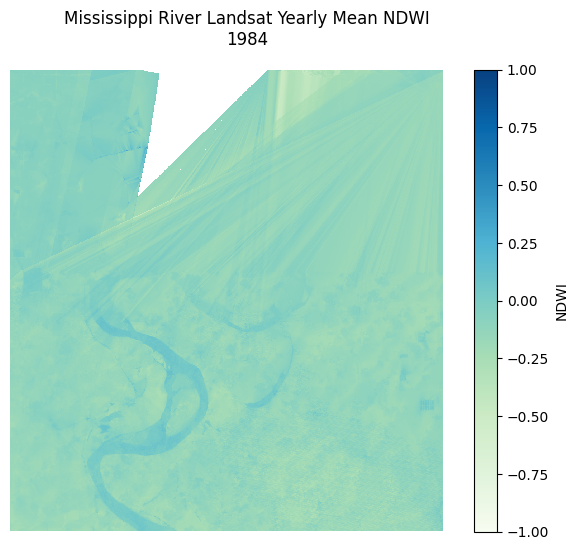

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    yearly_ndwi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='GnBu', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    
    fig.suptitle(f"Mississippi River Landsat Yearly Mean NDWI\n" + \
                    f"{yearly_ndwi['time'][frame].dt.strftime('%Y').values}")
    
init_plot = yearly_ndwi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'NDWI'}, cmap='GnBu', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(yearly_ndwi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once'))

In [ ]:
items_gdf['properties.datetime']

0      2024-12-31 16:37:36.266
1      2024-12-31 16:37:12.371
2      2024-12-15 16:37:38.003
3      2024-12-15 16:37:14.107
4      2024-12-14 16:43:40.237
                 ...          
5434   1984-05-06 16:10:35.346
5435   1984-04-29 16:04:36.633
5436   1984-04-29 16:04:12.660
5437   1984-04-20 16:10:50.216
5438   1984-04-20 16:10:26.385
Name: properties.datetime, Length: 5439, dtype: datetime64[ms]